<a id='top'></a>
<center><img src="../Images/iteso_logo.png" style="width:80px;height:80px; vertical- align:middle;" align="middle"></center>
  
<h1><center><b>INSTITUTO TECNOLÓGICO Y DE ESTUDIOS SUPERIORES DE OCCIDENTE</b></center></h1>
<h2><center><b>Maestría en Ciencia de Datos <br><br> Tesis: Atenuación de efectos acústicos en una Señal de Audio</b></center></h2>
<h3><center><b>
               Ing. Adrian Ramos Perez</b></center></h3>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/AdrianRamosDS/Thesis/blob/main/Tesis_ARP)

<a href="https://colab.research.google.com/github/AdrianRamosDS/Thesis/blob/main/Tesis_ARP_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***

Tabla de Contenido <a id='contents'></a>
-------
- [1. Extracción de los Datos (Data Ingestion and Versioning Step)](#dataextract)
    - [1.1 Señales de Audio](#audiosignals)
    - [1.2 Respuesta al Impulso](#ir)
    - [1.4 Convolución](#conv)
    - [1.5 Dataset Splitting](#split)

    <br>
    
- [2. Exploratory Data Analysis (Data Validation Step)](#eda)
    - [2.1 Medidas de Tendencia Central y Dispersión](#stats)
    - [2.2 Verificación de la Estacionariedad e Intervalos de Confianza](#stationary)
    
    <br>
    
- [3. Generación de los Vectores de Características (Preprocessing Step)](#features)
    - [Verificando la Correlación](#corr)
    
    <br>
    
- [4. Modelo y Experimentación (Model Training Step)](#models)
    - [Entrenamiento](#training)
    - [Tuneo Hiperparámetros con GridSearchCV](#tunning)
    
    <br>
    
- [6. Evaluación y Métricas de Evaluación (Model Analysis)](#metrics)
    - [R2](#r2)
    - [MSE](#mse)
    
    <br>
    
- [7. Conclusiones](#conclusions)

    <br>
    
- [8. Referencias](#ref)


In [1]:
#%conda install -c conda-forge scienceplots
#%conda install -c conda-forge mamba
#!mamba install -c conda-forge pandas=1.5.3

# 1. Extracción de los Datos <a id='dataextract'></a>
---

In [4]:
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int16Dtype # to remove xgboost api warning about compatibility
import soundfile as sf
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.get_cachedir()
import matplotlib.pyplot as plt
import scienceplots #plt.style.use('science')


In [5]:
import librosa as lb
import librosa.display
from IPython.display import Audio

## 1.1 Audio signals loading from .wav files: <a id='audiosignals'></a>

In [6]:
sr = 16000

In [8]:
path = '../Data/Train/'

samples, sr= lb.load("../Data/Train/ADS_train_audio_22kHz.wav", sr=sr, mono=True,offset=0.0,duration=None)
# Duración en segundos:
duration = len(samples)/sr
# Escuchar el audio:
Audio("../Data/Train/ADS_train_audio_22kHz.wav")
duration
print('Sampling rate: '+ str(sr) + ' Hz')
print('Duration:      '+ str(duration) + ' seconds')
print('No. of Samples: ', len(samples))

Sampling rate: 16000 Hz
Duration:      2.043375 seconds
No. of Samples:  32694


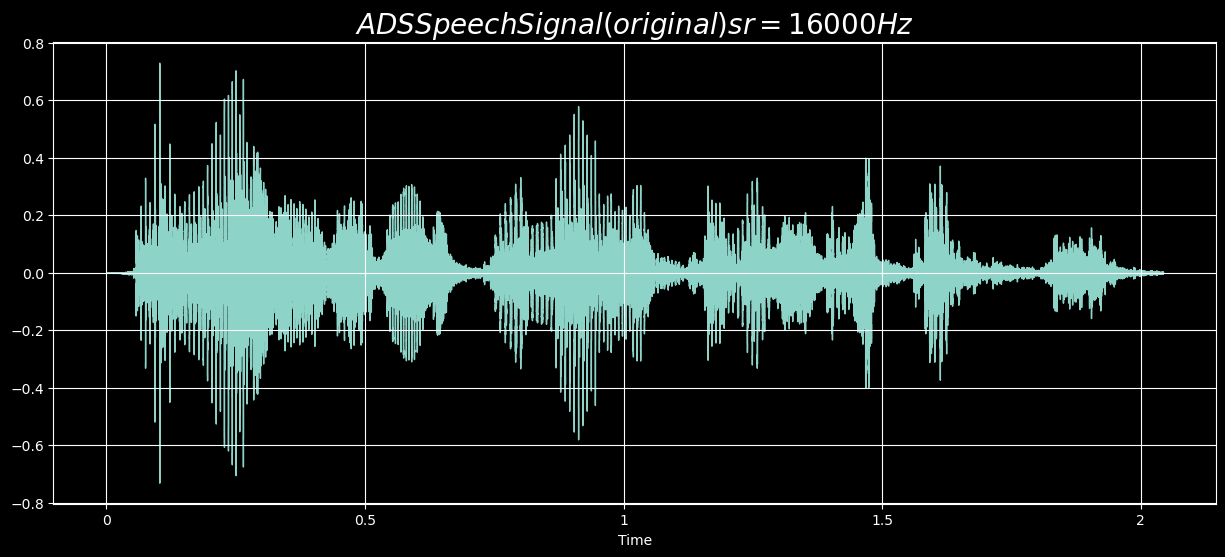

In [10]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(15,6))
plt.title(f'$ \t{{ADS Speech Signal (original)}} sr = {sr} Hz $', fontsize=20)
plt.grid(True)
lb.display.waveshow(y=samples,sr=sr)
plt.show()
fig.savefig(f'../Figures/Original_signal_sr={sr}')

## 1.2 Impulse Responses: <a id='ir'></a>

#### **22.050 kHz sampled Impulse Response:**

In [7]:
# Cargar respuesta al impulso:
ir_22k_samples, ir_22k_sr= lb.load("../Data/Train/ir_golpe22_short.wav", sr=None, mono=True,offset=0.0,duration=None)
ir_22k_duration = len(ir_22k_samples)/ir_22k_sr
print('Sampling rate: '+ str(ir_22k_sr) + ' Hz')
print('Duration:      '+ str(ir_22k_duration) + ' seconds')
print('No. of Samples:', len(ir_22k_samples))

Sampling rate: 22050 Hz
Duration:      0.16072562358276643 seconds
No. of Samples: 3544


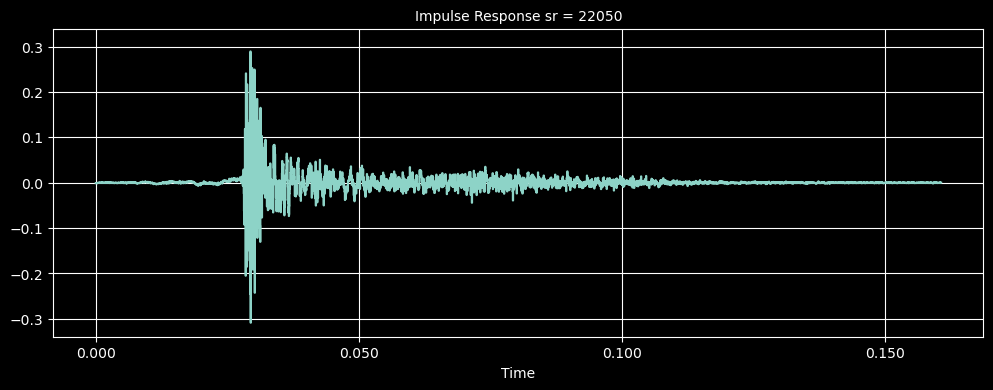

In [8]:
fig = plt.figure(figsize=(12,4))
plt.title(f'Impulse Response sr = {ir_22k_sr}', fontsize=10)
plt.grid()
lb.display.waveshow(y=ir_22k_samples,sr=ir_22k_sr)
plt.show()
fig.savefig(f'../Figures/Impulse_Response_sr={ir_22k_sr}')

#### **16 kHz sampled Impulse Response:**

In [9]:
ir_16k_samples, ir_16k_sr = lb.load("../Data/Train/ir_golpe16kHz.wav", sr=None, mono=True,offset=0.0,duration=None)
ir_duration = len(ir_16k_samples)/ir_16k_sr
print('Sampling rate: '+ str(ir_16k_sr) + ' Hz')
print('Duration:      '+ str(ir_duration) + ' seconds')
print('No. of Samples:', len(ir_16k_samples))

Sampling rate: 16000 Hz
Duration:      0.9573125 seconds
No. of Samples: 15317


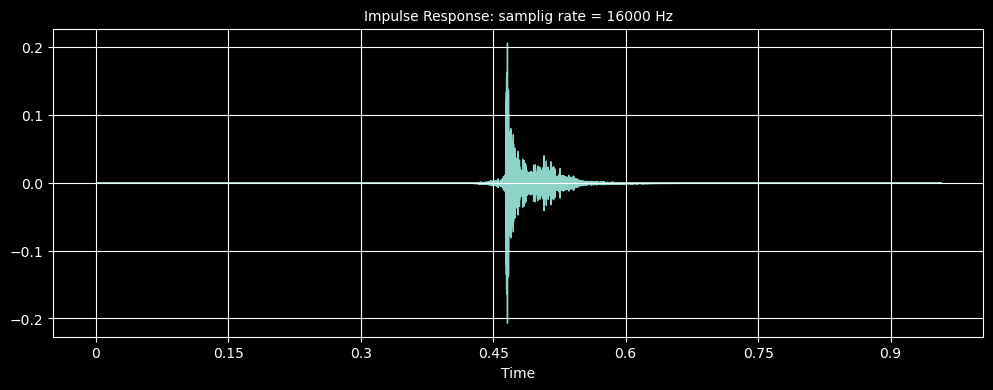

In [10]:
fig = plt.figure(figsize=(12,4))
plt.title(f'Impulse Response: samplig rate = {ir_16k_sr} Hz', fontsize=10)
plt.grid()
lb.display.waveshow(y=ir_16k_samples,sr=ir_16k_sr)
plt.show()
fig.savefig(f'../Figures/Impulse_Response_sr={ir_16k_sr}Hz')

In [11]:
ts_samples, ts_sr = lb.load("../Data/Train/QueenWatch1.wav", sr=sr, mono=True,offset=0.0,duration=None)
ts_duration = len(ts_samples)/ts_sr
ts_duration

3.766439909297052

### Different speech audio signals:

/tmp/ipykernel_179/1355302271.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,1))


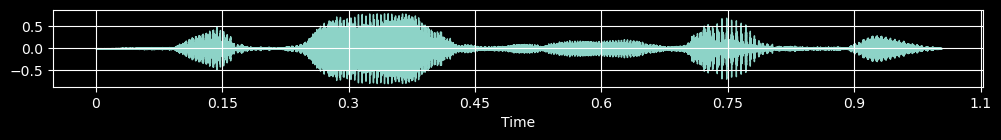

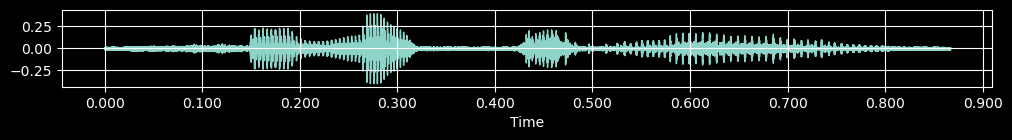

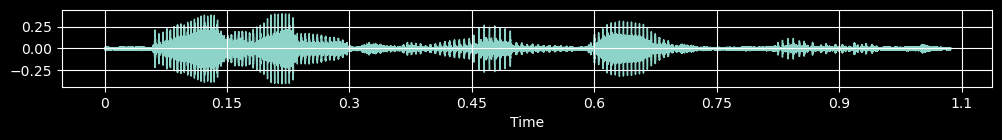

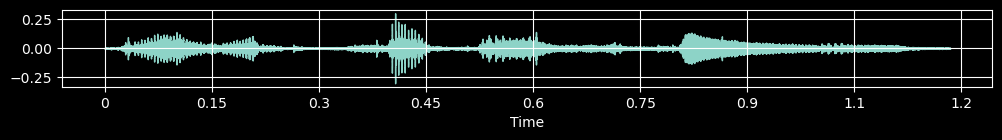

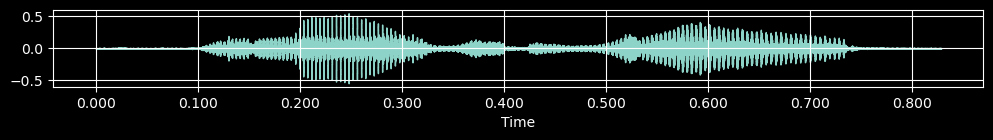

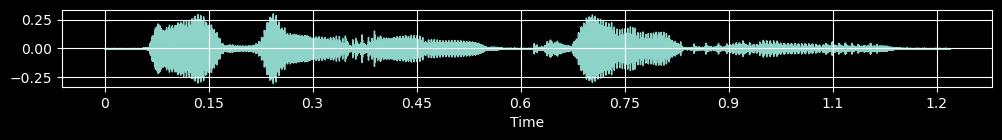

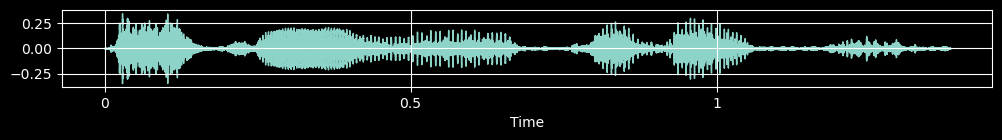

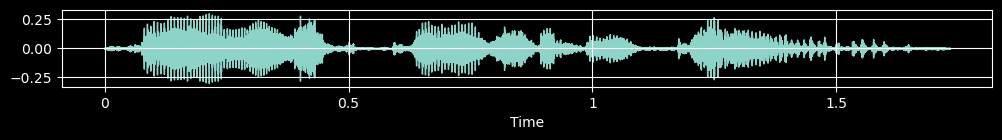

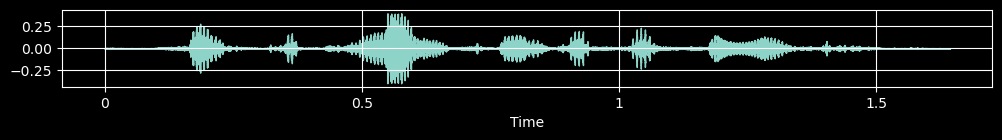

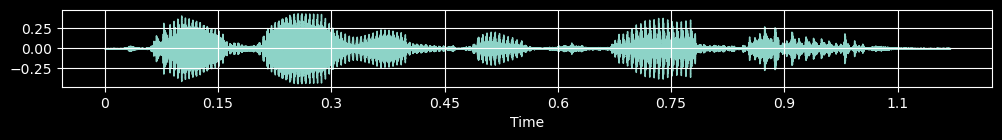

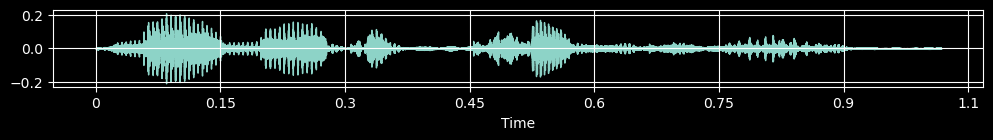

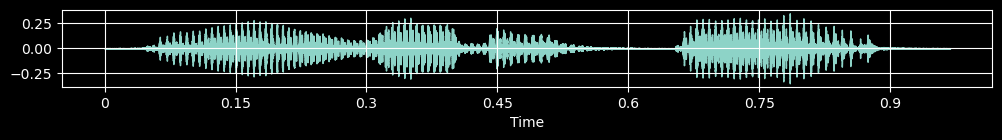

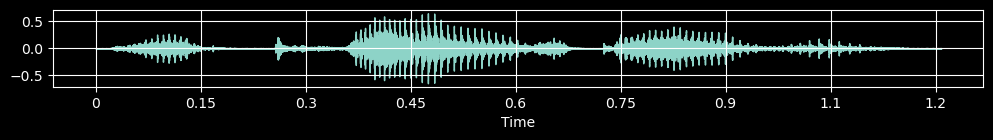

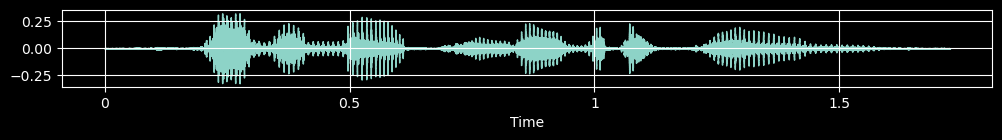

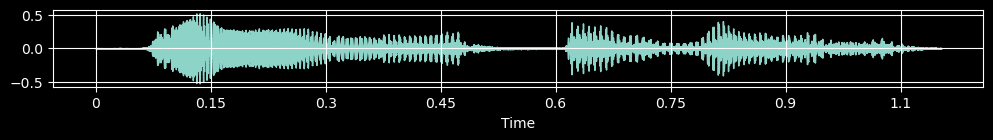

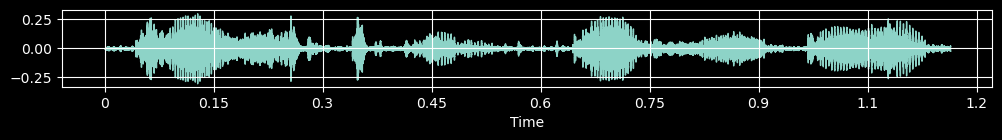

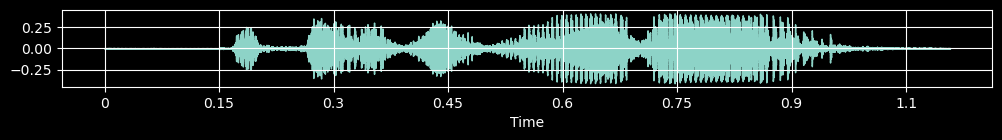

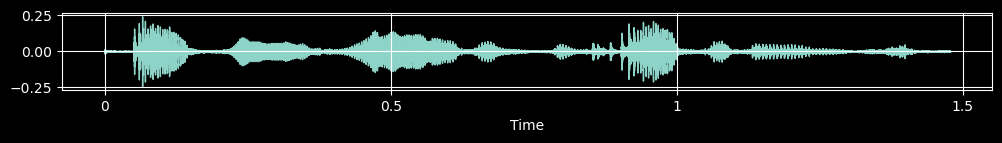

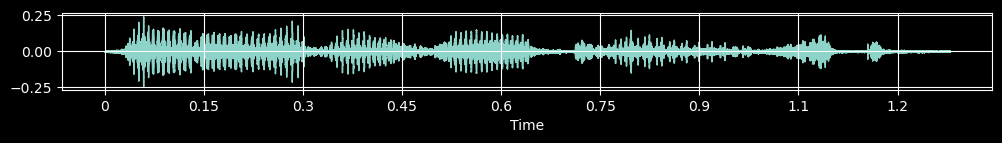

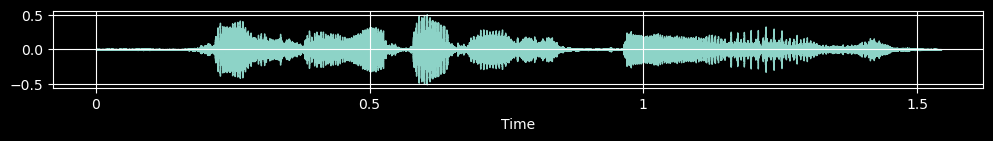

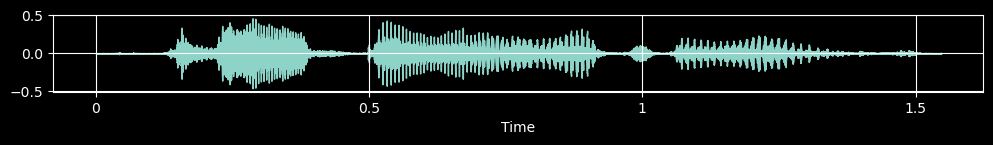

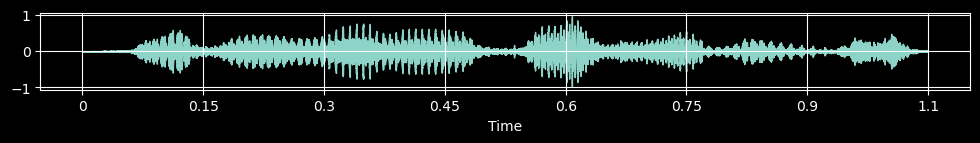

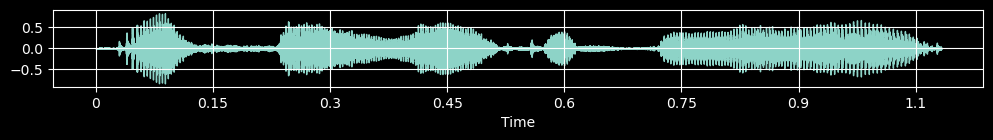

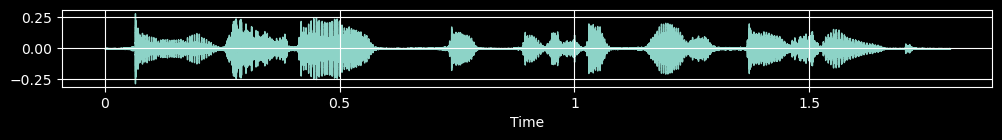

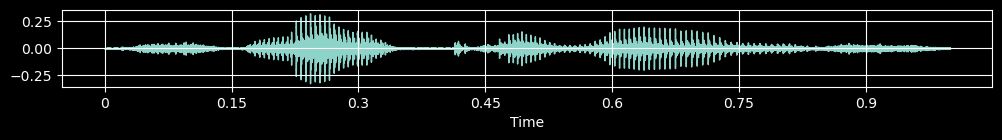

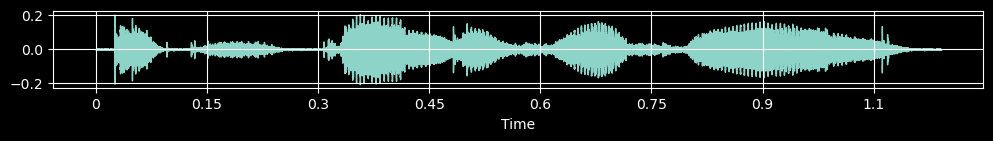

In [77]:
import os

root = '../Data/Train/16k/English'

def make_dataset(path):
        
    files_list = os.listdir(path)
    n_files = len(files_list) # Get the number of files in path directory
    signals = []
    
    for i in range(n_files):
        
        signal_path = os.path.join(path, files_list[i])  
        signal, sr = lb.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
        signals.append(signal)
        
    return signals, n_files

signals, n_signals = make_dataset(root)

for i in range(n_signals):
    fig = plt.figure(figsize=(12,1))
    lb.display.waveshow(y = signals[i], sr = sr)
    plt.grid(True) 

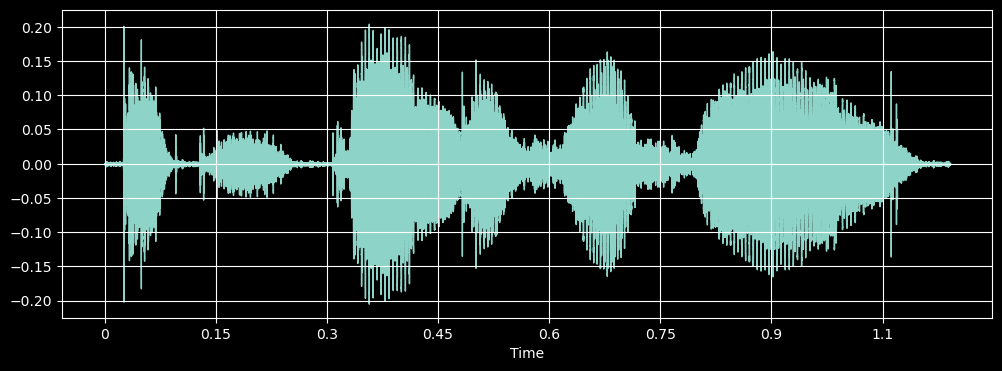

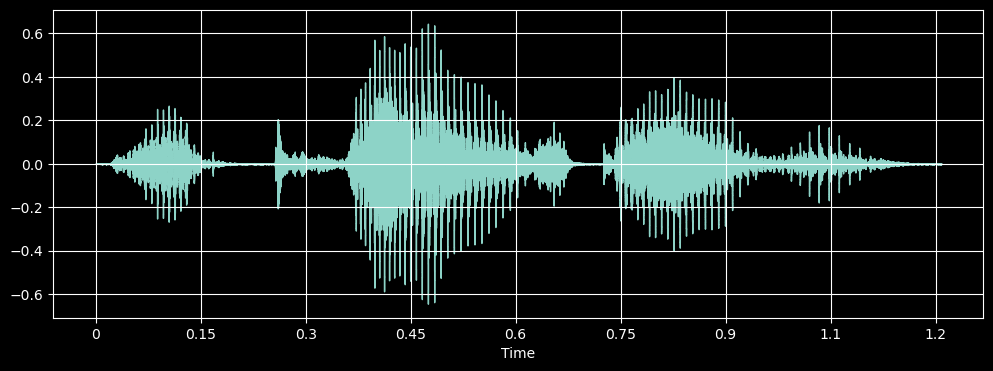

In [72]:
signal_1, sr = lb.load("../Data/Train/16k/English/84-121123-0005-16.wav", 
                       sr=None, mono=True, offset=0.0, duration=None)   

signal_2, sr = lb.load("../Data/Train/16k/English/251-137823-0005-16.wav", 
                   sr=None, mono=True, offset=0.0, duration=None)
        
signal_3, sr = lb.load("../Data/Train/16k/English/1673-143396-0016-16.wav", 
                   sr=None, mono=True, offset=0.0, duration=None)
        
signal_4, sr = lb.load("../Data/Train/16k/English/1988-24833-0013-16.wav", 
                   sr=None, mono=True, offset=0.0, duration=None)
        
signal_5, sr = lb.load("../Data/Train/16k/English/1988-147956-0021-16.wav", 
                   sr=None, mono=True, offset=0.0, duration=None)

fig = plt.figure(figsize=(12,4))
lb.display.waveshow(y=signal_1,sr=sr)
plt.grid(True) 

fig = plt.figure(figsize=(12,4))
lb.display.waveshow(y=signal_2,sr=sr)
plt.grid(True) 

### 1.3 Convolution between train signals and impulse response <a id='conv'></a>

In [11]:
conv_signal_1 = np.convolve(signal_1, ir_16k_samples, mode='same')
conv_signal_2 = np.convolve(signal_2, ir_16k_samples, mode='same')
conv_signal_3 = np.convolve(signal_3, ir_16k_samples, mode='same')
conv_signal_4 = np.convolve(signal_4, ir_16k_samples, mode='same')
conv_signal_5 = np.convolve(signal_5, ir_16k_samples, mode='same')



NameError: name 'signal_1' is not defined

In [16]:
# Convolución de numpy:
conv_signal = np.convolve(samples, ir_samples, mode='same')
# Plot the resulting singal:
fig = plt.figure(figsize=(12,8))
plt.title('Convolved signal (Impulse Response * Original Speech Signal)',fontsize=20)
plt.grid()
lb.display.waveshow(y=conv_signal,sr=sr)
plt.show()
fig.savefig(f'../Figures/Convolved_signal')
conv_signal.astype(np.int16).tofile('../Data/Train/conv_signal.wav')
sf.write('../Data/Train/convolved_signal.wav',conv_signal, sr, subtype=None)

NameError: name 'ir_samples' is not defined

---

### 1.3 Delayed Signal (Lags) Matrix generation

In [13]:
n_lag = 5

In [14]:
def lag_gen(signal, n_lag):
    
    # Lag matrix of dimmensions: (signal-n_lag rows x n_lag columns )    
    lag_matrix = np.zeros((len(signal)-n_lag, n_lag))   
    for i in range(n_lag):
             lag_matrix[:,i] = signal[i : len(signal) - n_lag + i]
    
    return lag_matrix

In [15]:
lag_matrix1 = lag_gen(signal = conv_signal_1, n_lag = n_lag)
lag_matrix2 = lag_gen(signal = conv_signal_2, n_lag = n_lag)
lag_matrix3 = lag_gen(signal = conv_signal_3, n_lag = n_lag)
lag_matrix4 = lag_gen(signal = conv_signal_4, n_lag = n_lag)
lag_matrix5 = lag_gen(signal = conv_signal_5, n_lag = n_lag)

NameError: name 'conv_signal_1' is not defined

In [ ]:
# Random plot one of the lagged signals:
r_int = np.random.randint(0,n_lag)
fig = plt.figure(figsize=(12,8))
plt.title(f'{r_int} lags sample of the Lagged Signals Matrix : ',fontsize=20)
plt.grid()
lb.display.waveshow(y=lag_matrix[r_int],sr=sr)
plt.show()

In [ ]:
X_train_tdnn = pd.DataFrame(np.vstack((lag_matrix1, lag_matrix2, lag_matrix3, lag_matrix4, lag_matrix5)) )
Y_train_tdnn = pd.DataFrame(np.hstack((signal_1[n_lag:], signal_2[n_lag:], signal_3[n_lag:], signal_4[n_lag:], signal_5[n_lag:])) )

train_df_tdnn = pd.concat([X_train_tdnn, Y_train_tdnn], axis=1, ignore_index=True)
train_df_tdnn.to_csv('train_df_tdnn.csv', index=False)

## Train dataset and Test dataset split



In [ ]:
X_train = lag_matrix
X_train.shape

In [ ]:
Y_train = samples[n_lag:]
Y_train.shape

# 2. Exploratory Data Analysis <a id='eda'></a>
---

# 3. Features Selection <a id='features'></a>
---

[Top](#contents)

# 4. Models and Experimentation <a id='model' ></a>
***

Se sigue un enfoque basando en una Red Neuronal de tipo Time-Delay, se contraste con un modelo XGBOOST

# 4.1 Time-Delay Neural Network model <a id='tdnn'></a>
***
En este tipo de red neuronal las entradas pasan como

In [ ]:
!pip show keras tensorflow

### Hyperparameters:

In [33]:
# param_grid format
tdnn_params = {
    'epochs': 200,
    'learning_rate': 0.05,
    'decay_rate': 1,
    'momentum': 0.8,
    'batch_size': 200
}
tdnn_params['decay_rate'] = tdnn_params['learning_rate']/tdnn_params['epochs']
tdnn_params

{'epochs': 200,
 'learning_rate': 0.05,
 'decay_rate': 0.00025,
 'momentum': 0.8,
 'batch_size': 200}

In [54]:
tdnn_net_arch = {
    'layer_count':3,
    'nn_i': 10,
    'nn_h1': 5,
    'nn_h2': 5,
}
tdnn_net_arch

{'layer_count': 3, 'nn_i': 10, 'nn_h1': 5, 'nn_h2': 5}

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Model definition:
def Time_Delay_NN(no_layers, input_layer, hiden_layer1, hiden_layer2):
    
    TDNN_model = Sequential()
    # Neurons
    nn_i, nn_h1, nn_h2 = input_layer, hiden_layer1, hiden_layer2
    
    # Layer(s) definition:
    TDNN_model.add(Dense(nn_i, input_shape=(n_lag,), activation="tanh", name="input_layer_2"))
    TDNN_model.add(Dense(nn_h1, activation="tanh", name="hidden_layer_1"))
    # model.add(Dense(nn_h2, activation="tanh", name="hidden_layer_2"))
    # model.add(TDNNLayer([-5,2],True, input_shape=(45053,1), activation="tanh"))

    # Output for Regression:
    TDNN_model.add(Dense(1, activation='linear', name="output_layer"))
    
    return TDNN_model

TDNN_model = Time_Delay_NN(3, 10, 5, 5)
# Compile model:
TDNN_model.compile(optimizer=Adam(learning_rate =tdnn_params['learning_rate']), loss='MeanSquaredError', metrics=['mse'])
x_train = X_train_tdnn
# xtrain = preprocessing.scale(xtrain)
y_train = Y_train_tdnn

## 4.3 Training Model <a id='training'></a>

In [36]:
import tensforflow_addons as tfa
import tqdm

tqdm_callback = tfa.callbacks.TQDMProgressBar()

TDNN_model_hist = TDNN_model.fit(x_train, y_train, 
                                 epochs=tdnn_params['epochs'], 
                                 batch_size=tdnn_params['batch_size'],
                                 callbacks=[tqdm_callback],
                                 verbose=1)
TDNN_model_hist

In [37]:
TDNN_model_hist

### 4.3.2 Plot the loss function and the metrics

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(13,12))
fig.subplots_adjust(hspace=0.3)
axs[0].set_title(f'Loss: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[0].plot(m_hist.history['loss'], 'r', label='train')
# ax.plot(m_hist.history['val_loss'], 'b' ,label='val')
axs[0].set_xlabel(r'Epoch', fontsize=20)
axs[0].set_ylabel(r'Loss', fontsize=20)
axs[0].grid(True)
axs[0].legend()
axs[0].tick_params(labelsize=20)

### 4.3.3 Plot the Mean-Square Error

In [ ]:
# fig, axs = plt.subplots(2, 2, figsize=(10,6))
# ax.plot(np.sqrt(m_hist.history['mean_squared_error']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mean_squared_error']), 'b' ,label='val')
axs[1].set_title(f'MSE: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20, fontname="Times New Roman", fontweight='bold')
axs[1].plot(np.sqrt(m_hist.history['mse']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mse']), 'b' ,label='val')
axs[1].set_xlabel(r'Epoch', fontsize=20)
axs[1].set_ylabel(r'MSE', fontsize=20)
axs[1].grid(True)
axs[1].legend()
axs[1].tick_params(labelsize=20)
#fig.savefig(f'../Figures/Loss_MSE_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr.png')

In [ ]:
!pip show pydot pydotplus graphviz

### 4.3. Model persistence

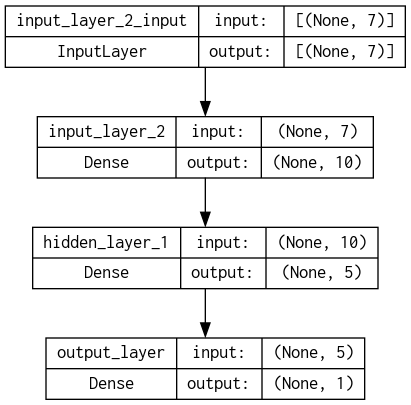

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(TDNN_model, to_file='../Figures/TDNN_model.png', show_shapes = True)

def model_export():
    
    
    
    
    return None

### Prediction

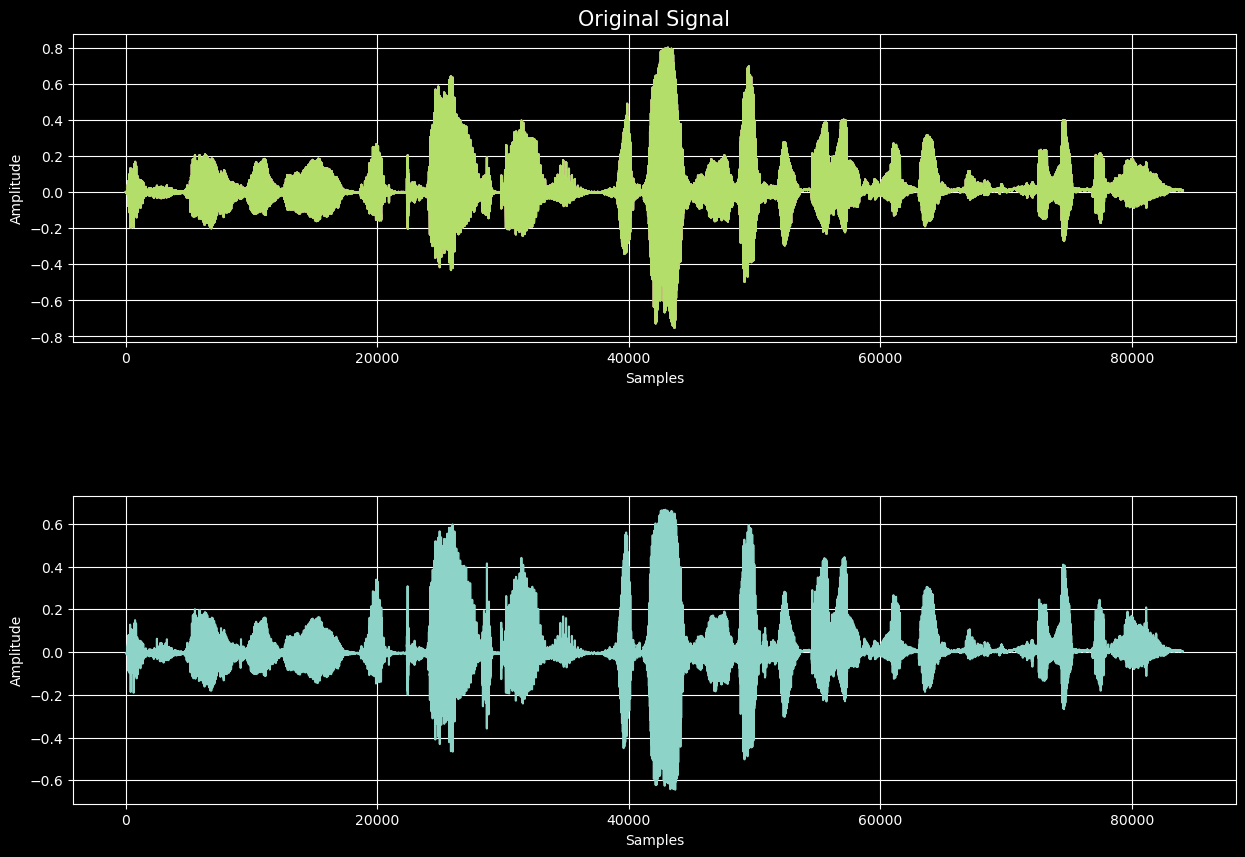

'../Data/TDNN_pred_signal_7lags_10i_5h1_5h2_200e_200bs_0.05lr.wav'

In [101]:
def predict(data):
    
    y_pred = TDNN_model.predict(data)
    
    return y_pred


path = '../Data/'
file_name = f"TDNN_pred_signal_{n_lag}lags_{tdnn_net_arch['nn_i']}i_{tdnn_net_arch['nn_h1']}h1_{tdnn_net_arch['nn_h2']}h2_{ tdnn_params['epochs'] }e_{ tdnn_params['batch_size'] }bs_{ tdnn_params['learning_rate']}lr"
format_wav = '.wav'
format_png = '.png'
s = path + file_name + format_wav

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
#plt.tight_layout(pad=0.5)
axs[0].set_title(f'Original Signal', fontsize=15)
axs[0].plot(X_train_tdnn)
axs[0].set_xlabel('Samples', fontsize=10)
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
#axs[1].set_title(f'Y_hat: {n_lag} lags, Neurons: {nn_i}i, {nn_h1}h, {nn_h2}h2, Epochs:{Epochs}, Batch:{Batch_size}, LR:{Learning_rate}', fontsize=20)
axs[1].plot(y_pred)
axs[1].set_xlabel('Samples', fontsize=10)
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/{file_name}.png', dpi=450 )

# Save to sound file:
sf.write('../Data/X_train.wav', X_train_tdnn, ir_16k_sr, subtype=None)
sf.write('../Data/Y_train.wav', Y_train_tdnn, ir_16k_sr, subtype=None)
sf.write(s, y_pred, ir_16k_sr, subtype=None)
s

## 4. Performance Evaluation:

In [ ]:
from sklearn.metrics import (r2_score, mean_squared_error, make_scorer)

In [95]:
tdnn_metrics = {
    'R2_score': r2_score(Y_train_tdnn, y_pred),
    'MSE': (mean_squared_error(Y_train_tdnn, y_pred)**0.5),
    'MAE': mean_absolute_error(Y_train_tdnn, y_pred),
    'MAPE': mean_absolute_percentage_error(Y_train_tdnn, y_pred)
}
tdnn_metrics

{'R2_score': 0.8855717075503367,
 'MSE': 0.030656625596034003,
 'MAE': 0.017368473,
 'MAPE': 35960996000.0}

In [ ]:


x_min,x_max = min(y_train),max(y_train)
xline = np.linspace(x_min,x_max)

fig = plt.figure(figsize=(6,6))
plt.scatter(ytrain,y_pred,label='Estimation')
plt.plot(xline,xline,'k--',label='Perfect estimation')
plt.xlabel('Real output', fontsize=12)
plt.ylabel('Estimation output', fontsize=12)
plt.suptitle('R^2=%0.4f'%R2_score, fontsize=12)
plt.title(f'{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{Learning_rate}lr', fontsize=12)
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../Figures/R2_{n_lag}lags_{nn_i}i_{nn_h1}h1_{nn_h2}h2_{Epochs}e_{Batch_size}bs_{TDNN_lr}lr.png', dpi=450)


## 4. Testing another Signal:
***

In [ ]:

#%%  Test

# Queen_y_pred = model.predict(ts_samples)
# sf.write('../Data/queen_predicted_signal.wav',Queen_y_pred, ts_sampling_rate, subtype=None)
# plt.show()
# plt.figure()
# plt.title('Queen Predicted Signal')
# plt.plot(Queen_y_pred,c='r')

# score = model.evaluate(matrix, samples[3:])
# print('Test loss:', score[0])
# print('Test mse:', score[1])

# corr = sig.correlate(y_pred, y_pred)

# plt.figure()
# plt.title('Signals Correlation')
# plt.plot(corr)
# plt.show()

#%% Hyperparameter tunning
from sklearn.model_selection import GridSearchCV

# RandomSearchCV


### Save weights to HDF5

In [63]:
from keras.models import model_from_json

TDNN_model.save_weights(f"../Models/TDNN_model_weights.h5")
TDNN_model.save(f"../Models/TDNN_model.h5")
TDNN_model

In [66]:
#%% Retrieve the model: load json and create model
with open('../Models/TDNN_model.h5', 'r') as json_file:    
    saved_model = json_file.read()

#saved_model_ = model_from_json(saved_model)
# load weights into new model:
# model_.load_weights("../Figures/TDNN_model.h5")
# print("Model loaded")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

## 4.3. XGBoost Model <a id='xgb'></a>
***

In [83]:
!pip show xgboost

Name: xgboost
Version: 1.5.1
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages
Requires: numpy, scipy
Required-by: 


In [73]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [74]:
xgb_model = xgb.XGBRegressor()
xgb_model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### Parameter Definition:

In [77]:
param_grid = {
    'n_estimators': range(100, 160, 20), # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': [0.05], # Eta
    'max_depth': range(2, 4, 1),
    'subsample': [0.2, 0.5] # Submuestreo aleatorio para prevenir overfitting
}

In [78]:
grid_search = GridSearchCV(estimator=xgb_model, 
                  param_grid=param_grid,
                  #scoring='neg_mean_squared_error',
                  scoring='r2',
                  n_jobs=1, # All proceiisors
                  cv=5,
                  verbose=2)

grid_search.fit(X_train_tdnn, Y_train_tdnn)
print("Mejores parámetros:",grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.9s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.9s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   0.9s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.2; total time=   1.0s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.5; total time=   1.3s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.2; total time=   1.0s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.2; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.2; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.2; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.2; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.5; total time=   1.3s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=120, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.2; total time=   1.3s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.2; total time=   1.3s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.5; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.5; total time=   1.8s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.5; total time=   1.8s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=2, n_estimators=140, subsample=0.5; total time=   1.8s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.2; total time=   1.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.2; total time=   1.2s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.5; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.2; total time=   1.4s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.2; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.2; total time=   1.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.2; total time=   1.4s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.2; total time=   1.4s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.5; total time=   1.8s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.5; total time=   2.0s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.5; total time=   2.0s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.5; total time=   2.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=120, subsample=0.5; total time=   2.0s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.2; total time=   1.6s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.2; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.2; total time=   1.6s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.2; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.2; total time=   1.7s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.5; total time=   2.1s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.5; total time=   2.3s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.5; total time=   2.4s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.5; total time=   2.5s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END learning_rate=0.05, max_depth=3, n_estimators=140, subsample=0.5; total time=   2.4s


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 140, 'subsample': 0.5}


In [ ]:
best_params = {
    'n_estimators': 110, # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': 0.05, # Eta
    'max_depth': 2,
    'subsample': 0.2
    }
xgb_best_model = xgb.XGBRegressor(
                             n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'],
                             eval_metric = 'r2',
                             learning_rate = best_params['learning_rate'],
                             verbosity = 4,
                             n_jobs = -1,
                             gamma = 1,)

In [79]:
xgb_best_model = grid_search.best_estimator_
xgb_best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=140, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Save model for model persistence:

In [84]:
import pickle

xgb_best_model.save_model("../Models/xgb_best_model.json")
pickle.dump(xgb_best_model, open("../Models/xgb_best_model.pkl", "wb"))

In [ ]:
def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

xgb_best_model = load_pkl('../Models/xgb_best_model.pkl')
xgb_best_model

### Realizar predicción sobre la señal original:

In [85]:
xgb_best_Yhat = xgb_best_model.predict(X_train_tdnn)
xgb_best_Yhat.shape

(84047,)

### Calcular scores de la predicción del modelo:

In [86]:
xgb_best_rmse = (mean_squared_error(Y_train_tdnn, xgb_best_Yhat)**0.5)
xgb_best_mae = mean_absolute_error(Y_train_tdnn, xgb_best_Yhat)
xgb_best_mape = mean_absolute_percentage_error(Y_train_tdnn, xgb_best_Yhat)
xgb_best_r2 = r2_score(Y_train_tdnn, xgb_best_Yhat)
print('RMSE: {0:.3f}'.format(xgb_best_rmse))
print('MAE: {0:.3f}'.format(xgb_best_mae))
print('MAPE: {0:.3f}'.format(xgb_best_mape))
print('R^2: {0:.3f}'.format(xgb_best_r2))

RMSE: 0.034
MAE: 0.019
MAPE: 23930595328.000
R^2: 0.861


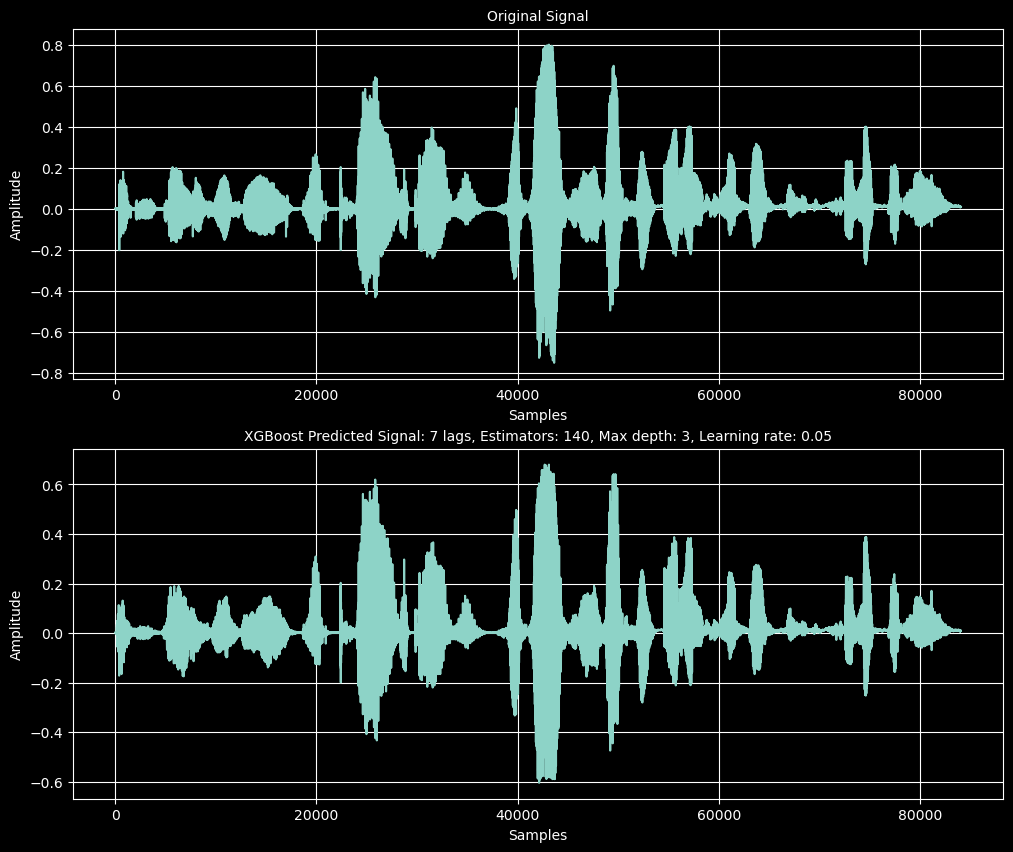

In [89]:

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.subplots_adjust(hspace=0.2)
# plt.tight_layout(pad=0.7)
axs[0].set_title(f'Original Signal', fontsize=10)
axs[0].plot(Y_train_tdnn)
axs[0].set_xlabel('Samples', fontsize=10)
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'XGBoost Predicted Signal: {n_lag} lags, Estimators: {xgb_best_model.n_estimators}, Max depth: {xgb_best_model.max_depth}, Learning rate: {xgb_best_model.learning_rate}', fontsize=10)
axs[1].plot(xgb_best_Yhat)
axs[1].set_xlabel('Samples', fontsize=10)
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/xgb_yhat_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.png', dpi=450 )


In [ ]:
# Save to sound file:
sf.write(f'../Data/XGB_pred_signal_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.wav',xgb_best_Yhat, sr, subtype=None)


In [ ]:
# Graph and save the predicted signal:


#%% Save a model to JSON

# serialize model to JSON
model_json = model.to_json()

with open("../Figures/TDNN_model.json", "w") as json_file:
    json_file.write(model_json)


## 7. Conclusiones <a id='conclusiones'></a>
***

[Top](#top)

# 8. Referencias <a id='ref'></a>
***
[]

[]

[]

